# *Quantification of short term signaling by the epidermal growth factor receptor*

### By Kholodenko BN et al. (1999)

__Abstract:__

During the past decade, our knowledge of molecular mechanisms involved in growth factor signaling has proliferated almost explosively. However, the kinetics and control of information transfer through signaling networks remain poorly understood. This paper combines experimental kinetic analysis and computational modeling of the short term pattern of cellular responses to epidermal growth factor (EGF) in isolated hepatocytes. The experimental data show transient tyrosine phosphorylation of the EGF receptor (EGFR) and transient or sustained response patterns in multiple signaling proteins targeted by EGFR. Transient responses exhibit pronounced maxima, reached within 15-30 s of EGF stimulation and followed by a decline to relatively low (quasi-steady-state) levels. In contrast to earlier suggestions, we demonstrate that the experimentally observed transients can be accounted for without requiring receptor-mediated activation of specific tyrosine phosphatases, following EGF stimulation. The kinetic model predicts how the cellular response is controlled by the relative levels and activity states of signaling proteins and under what conditions activation patterns are transient or sustained. EGFR signaling patterns appear to be robust with respect to variations in many elemental rate constants within the range of experimentally measured values. On the other hand, we specify which changes in the kinetic scheme, rate constants, and total amounts of molecular factors involved are incompatible with the experimentally observed kinetics of signal transfer. Quantitation of signaling network responses to growth factors allows us to assess how cells process information controlling their growth and differentiation.



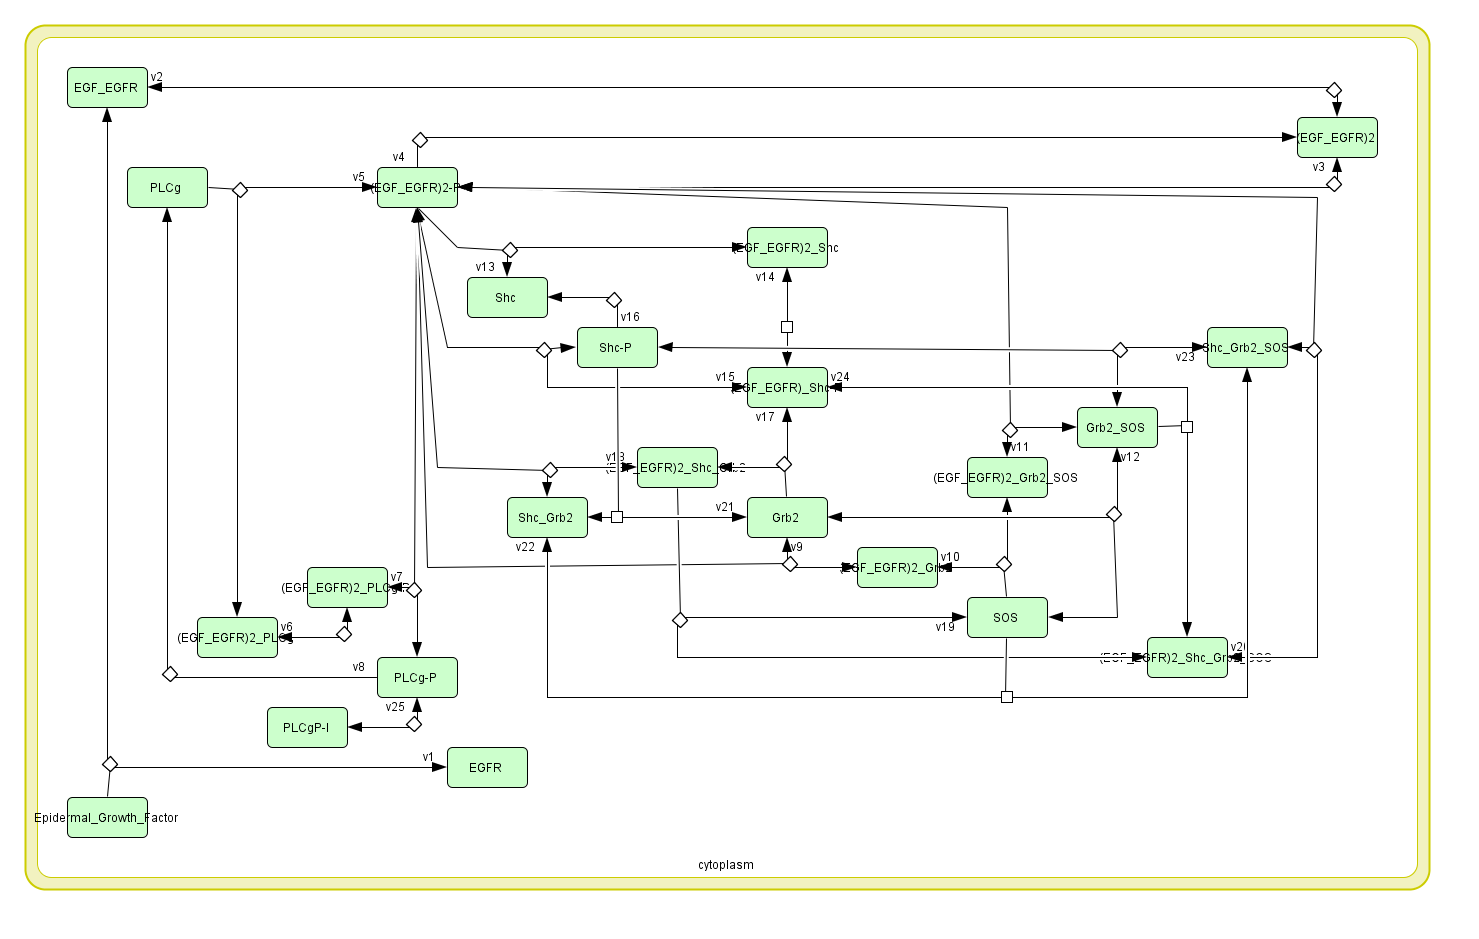

In [1]:
## Libraries:

# a) Bond graphs
import BondGraphTools as bgt

# b) Data extraction
from pyomexmeta import RDF, eUriType
import os
import sys
import xml.etree.ElementTree as ET
import rdflib
from lxml import etree
import re

# c) General
import copy
import difflib
import numpy as np
import pandas as pd
import math
import operator as op
import ast
import re

# d) Plot
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.font_manager as font_manager
import matplotlib.colors
from pylab import rcParams
import matplotlib.image as mpimg

# sbml
from libsbml import*
import simplesbml 

# Integration and fitting
from scipy.optimize import curve_fit, minimize, least_squares, newton_krylov, basinhopping
from scipy  import integrate
import scipy.stats as stats
from symfit import parameters, variables, log, Fit, GreaterThan, Model
from symfit.core.minimizers import BasinHopping


The tests rely on tellurium to construct the models
Since tellurium is not installed the tests can't be run
If you want to run the tests, pip install tellurium first


In [38]:
simulations = ['/Users/nsha457/Documents/Jupyter_files/SBML_AnnotMerge/BIOMD0000000048 (EGFR)/solutions.csv']  
locations=['/Users/nsha457/Documents/Jupyter_files/SBML_AnnotMerge/Verified_other_conversions/BIOMD0000000048 (EGFR)/BIOMD0000000048.xml']


In [39]:
# Initial information about the SBML model

reader = SBMLReader()
document = reader.readSBML(locations[0])
document.getNumErrors()

model_lib = document.getModel()
model_simple = simplesbml.loadSBMLFile(locations[0])


print ('Num compartmetns = ', model_simple.getNumCompartments())
print ('Num parameters =', model_simple.getNumParameters())
print ('Num species =', model_simple.getNumSpecies())
print ('Num reactions = ', model_simple.getNumReactions())
print (model_simple.getListOfCompartmentIds())
print (model_simple.getListOfAllSpecies())
print ('List of reactions = ', model_simple.getListOfReactionIds())
print ('List of rules = ', model_simple.getListOfRuleIds())
print ('List of parameters = ', model_simple.getListOfParameterIds())

compartmentSize = {}
for i in range(model_simple.getNumCompartments()):
    compartmentSize[model_simple.getCompartmentId(i)] = model_simple.getCompartmentVolume(i)
print(compartmentSize)

Num compartmetns =  1
Num parameters = 0
Num species = 23
Num reactions =  25
['compartment']
['EGF', 'R', 'Ra', 'R2', 'RP', 'PLCg', 'RPLCg', 'RPLCgP', 'PLCgP', 'Grb', 'RG', 'SOS', 'RGS', 'GS', 'Shc', 'RSh', 'RShP', 'ShP', 'RShG', 'ShG', 'RShGS', 'ShGS', 'PLCgl']
List of reactions =  ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25']
List of rules =  []
List of parameters =  []
{'compartment': 3e-12}


In [40]:
def watchdog(idAndAnnotations):
    
    # Finding identical annotations among the entities (should return Null)
    checkSimilarities = True
    for i in range(len(idAndAnnotations.keys())):
        for j in range(i+1,len(idAndAnnotations.keys())):
            if idAndAnnotations[list(idAndAnnotations)[i]] == idAndAnnotations[list(idAndAnnotations)[j]]:
                print("Pairs with identical annotations in the same model: ",list(idAndAnnotations)[i],list(idAndAnnotations)[j])
                print('----------')
                print('Change the annotations of the entities/their compartment to be distinctive.')
                checkSimilarities = False

                img = mpimg.imread('Watchdog.jpg')
                imgplot = plt.imshow(img)
                plt.show()
                
    return checkSimilarities

In [41]:
# Reading and extracting annotations from the sbml files

def annotationExtraction(address,model_lib):

    modelURI = SBase.getURI(model_lib) 

    root=ET.parse(open(address)).getroot()
    idAndAnnotations = {}
    compartments=[]
    for child in root:
        for grand in child:
            if grand.tag == '{'+str(modelURI)+'}'+'listOfCompartments':
                for g in grand:
                    for g1 in g:
                        for g2 in g1:
                            for g3 in g2:
                                for g4 in g3:
                                    for g5 in g4:
                                        for g6 in g5:
                                            compartments.append((g.attrib.get('id'),g6.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}resource')))



            if grand.tag == '{'+str(modelURI)+'}'+'listOfSpecies':
                for g in grand: 
                    idAndAnnotations[g.attrib.get('id')] = []
                    for i,j in compartments:
                        if g.attrib.get('compartment') == i:
                            idAndAnnotations[g.attrib.get('id')].append(j)
                    for g1 in g:
                        for g2 in g1:
                            for g3 in g2:
                                for g4 in g3:
                                    for g5 in g4:
                                        for g6 in g5:
                                            idAndAnnotations[g.attrib.get('id')].append(g6.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}resource'))
  
    checkSimilarities = watchdog(idAndAnnotations)
    
    if checkSimilarities == True:                                    
        return[compartments,idAndAnnotations]
    else:
        return


In [42]:
def reactionsCategorizing(model_lib,model_simple,compartments,idAndAnnotations):
    
    reaction_reactants={}; reaction_products={}; Synthesis=[]; Dtype=[]

    for reaction in model_simple.getListOfReactionIds():
        reaction_reactants[reaction]=[]
        reaction_products[reaction]=[]

        reactNum=model_simple.getNumReactants(reaction)
        prodNum=model_simple.getNumProducts(reaction)

        if reactNum is 0:
            Synthesis.append(reaction)
        if prodNum is 0:
            Dtype.append(reaction)


        for i in range(reactNum):
            for name,identifier in compartments:
                if idAndAnnotations[model_simple.getReactant(reaction, i)] ==  [str(identifier)]:  # if a component has no annotation but the one for any of the compartments, don't use its annotation
                    reaction_reactants[reaction].append((model_simple.getReactantStoichiometry(reaction, i), \
                                                 model_simple.getReactant(reaction, i)))
                    break
                else:
                    reaction_reactants[reaction].append((model_simple.getReactantStoichiometry(reaction, i), \
                                                         idAndAnnotations[model_simple.getReactant(reaction, i)]))
                    break


        for ii in range(prodNum):
            for name,identifier in compartments:
                if idAndAnnotations[model_simple.getProduct(reaction, ii)] ==  [str(identifier)]:  # if a component has no annotation but the one for any of the compartments, don't use its annotation
                    reaction_products[reaction].append((model_simple.getProductStoichiometry(reaction, ii), \
                                                 model_simple.getProduct(reaction, ii)))
                    break
                else:
                    reaction_products[reaction].append((model_simple.getProductStoichiometry(reaction, ii), \
                                                         idAndAnnotations[model_simple.getProduct(reaction, ii)]))
                    break
            


    reversibles=[]; irreversibles=[]; 
    for (reaction,r) in zip(model_simple.getListOfReactionIds(),range(len(model_lib.getListOfReactions()))):

        if model_lib.getListOfReactions()[r].getReversible() is True:
            reversibles.append(reaction)
        elif reaction not in [synth for synth in Synthesis] and reaction not in [d for d in Dtype]:
            irreversibles.append(reaction)  

 
    speciesId=[]
    for species in model_simple.getListOfAllSpecies():
        for reaction in reversibles+irreversibles:
            for stoichiometry,reactant in reaction_reactants[reaction]:
                if species in [x for x in idAndAnnotations if idAndAnnotations[x]==reactant] and species not in [d for d in speciesId]:
                    speciesId.append(species)

            for stoichiometry,product in reaction_products[reaction]:
                if species in [x for x in idAndAnnotations if idAndAnnotations[x]==product] and species not in [d for d in speciesId]:
                    speciesId.append(species)


    return [speciesId,reversibles,irreversibles,reaction_reactants,reaction_products,Synthesis,Dtype]

In [65]:
# Unit detection and scaling

def unitConversion(solutions,address):
    
    scales = ['-12','-9','-6','-3','1']
    prefixes = ['pM', 'nM', 'uM', 'mM', 'M']
    
    modelURI = SBase.getURI(model_lib) 
    root=ET.parse(open(address)).getroot()
    Units={}
    for child in root:
        for grand in child:
            if grand.tag == '{'+str(modelURI)+'}'+'listOfUnitDefinitions':
                
                for g in grand:
                    
                    for g1 in g:
                        for g2 in g1:
                            Units[g.attrib.get('id')] = (g2.attrib.get('kind'),g2.attrib.get('scale'))
                            
    if Units=={}:
        concentrationUnit = 'M'
    else:

        for a,b in zip(scales,prefixes):
            if Units['substance'][1] == a:
                concentrationUnit = b
        
    
    print('The unit for concentration in this model is: ',concentrationUnit)
    
    print('Enter a normalisation factor for concentration ("enter 1 if you wish no normalisation"): ')
    normalisationFactor = float(input())
    
      
    for column in solutions:
        if column != 'Time' and column != 'compartment':
            solutions[column]=solutions[column].apply(lambda x: x*normalisationFactor)


    print('\n \n')
    
    
    
    return [solutions,concentrationUnit,normalisationFactor]
        

In [66]:
listOfComponents={}; listOfConnections={}; idAndAnnotationsAll={}; solutionsAll={};
i=0
for address,simulation in zip(locations,simulations):

    reader = SBMLReader()
    document = reader.readSBML(address)
    error = document.getNumErrors()

    if error:            
        print("Error found in ",address)
        break

    else:          
        model_lib = document.getModel()
        model_simple = simplesbml.loadSBMLFile(address)
        
                        
        [unifiedSolution,concentrationUnit,normalisationFactor] = unitConversion(pd.read_csv(simulation),address)

        [compartments,idAndAnnotations] = annotationExtraction(address,model_lib)

        [speciesId,reversibles,irreversibles,reaction_reactants,reaction_products,Synthesis,Dtype] = reactionsCategorizing(model_lib,model_simple,compartments,idAndAnnotations)            



The unit for concentration in this model is:  nM
Enter a normalisation factor for concentration ("enter 1 if you wish no normalisation"): 
1

 



In [67]:
def findOptimum(known,rowM,reversibleMA,irreversibleMM,irreversibleMA,reversibleMM):
    
    knownValues = copy.deepcopy(known)


# M initial 

    M = np.zeros([len(knownValues),len(rowM)]) 



# M matrix values for reversible MAs
    for i,reaction in zip(range(len(reversibleMA)),reversibleMA):
        for stoichiometry,reactant in reaction_reactants[reaction]:
            for row in range(len(rowM)):     
                if rowM[row] == reactant:  
                    M[i][row] = -stoichiometry



        for stoichiometry,product in reaction_products[reaction]:
            for row in range(len(rowM)):     
                if rowM[row] == product:                    
                    M[i][row] = stoichiometry

    lastline = copy.deepcopy(i+1)



# M matrix values for irreversible MMs
    for i,reaction in zip(range(lastline,lastline+2*len(irreversibleMM),2),irreversibleMM): # K_P/K_S = 1e-3
    
        for stoichiometry,reactant in reaction_reactants[reaction]:
            for row in range(len(rowM)):
                if rowM[row] == reactant:
                    M[i][row] = -stoichiometry
        for stoichiometry,product in reaction_products[reaction]:
            for row in range(len(rowM)):
                if rowM[row] == product:
                    M[i][row] = stoichiometry
        for row in range(len(rowM)):        
            if rowM[row] == reaction+' X':
                M[i][row] = 1
                
                
        for row in range(len(rowM)):
            if rowM[row] == reaction+'_r2':
                M[i+1][row] = 1
            if rowM[row] == reaction+'_ES':
                M[i+1][row] = 1

    lastline = copy.deepcopy(i+2)

# M matrix values for irreversible MAs
    for i,reaction in zip(range(lastline,lastline+1*len(irreversibleMA),1),irreversibleMA):

        for stoichiometry,reactant in reaction_reactants[reaction]:
            for row in range(len(rowM)):     
                if rowM[row] == reactant:  
                    M[i][row] = -stoichiometry


        for stoichiometry,product in reaction_products[reaction]:
            for row in range(len(rowM)):     
                if rowM[row] == product:                    
                    M[i][row] = stoichiometry

        for row in range(len(rowM)):            
            if rowM[row] == reaction+' X':
                M[i][row] = 1

    lastline = copy.deepcopy(i+1)      


# M matrix values for reversible MMs
    for i,reaction in zip(range(lastline,lastline+2*len(reversibleMM),2),reversibleMM):

        for row in range(len(rowM)):

            for stoichiometry,reactant in reaction_reactants[reaction]:  # K_P/K_S = B/A
                if rowM[row] == reactant:
                    M[i][row] = -stoichiometry
            for stoichiometry,product in reaction_products[reaction]:
                if rowM[row] == product:
                    M[i][row] = stoichiometry


            if rowM[row] == reaction+'_r2':  # (r2*K_P)/(r1*K_S) = D/C
                M[i+1][row] = 1
            for stoichiometry,product in reaction_products[reaction]:
                if rowM[row] == product:
                    M[i+1][row] = stoichiometry
            if rowM[row] == reaction+'_r1':
                M[i+1][row] = -1
            for stoichiometry,reactant in reaction_reactants[reaction]:
                if rowM[row] == reactant:
                    M[i+1][row] = -stoichiometry



    lastline = copy.deepcopy(i+2)



    logKnownValues = [];

    for k in knownValues:
        logKnownValues.append(math.log(k))

    logKnownValues = np.array(logKnownValues)


    Mpinv = np.linalg.pinv(np.array(M))
    logU = Mpinv.dot(logKnownValues)

    thermodynamics = [math.exp(i) for i in list(logU)]
        
        
       
    
    
    return thermodynamics

In [68]:
def irreversibleAndReversible(model_lib,model_simple,speciesId,reaction_reactants,reaction_products,solutions,idAndAnnotations):
    
    reversibleMA = []
    reversibleMM = []
    irreversibleMM = []
    irreversibleMA = []
    known = []
    Vm = {}  # saving Vm for each irreversible MM to use in later calculations
    Km = {}
    rowM=[]
    AA={}
    CC={}
    
    for s in speciesId:
         rowM.append([x for x in idAndAnnotations.values() if idAndAnnotations[s]==x][0])
    
    
    for (reaction,r) in zip(model_simple.getListOfReactionIds(),range(len(model_lib.getListOfReactions()))):
        
        if SBase.getSBOTermID(model_lib.getListOfReactions()[r]) == 'SBO:0000079': # reversible MA
            reversibleMA.append(reaction)

            phi_Xr_1 = 1
            phi_Xp_1 = 1
            phi_Xr_e = 1
            phi_Xp_e = 1
            

            for stoichiometry,reactant in reaction_reactants[reaction]:

                phi_Xr_1 = phi_Xr_1 * pow(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]][1],stoichiometry)
                phi_Xr_e = phi_Xr_e * pow(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]][len(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]])-1],stoichiometry)

            for stoichiometry,product in reaction_products[reaction]:        
                phi_Xp_1 = phi_Xp_1 * pow(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]][1],stoichiometry)
                phi_Xp_e = phi_Xp_e * pow(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]][len(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]])-1],stoichiometry)

            # compartment for a reactant/species in the reaction
            compartmentId1 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0])
            compartmentId2 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==product][0])
            compartmentVolume1 = model_simple.getCompartmentVolume(compartmentId1)
            compartmentVolume2 = model_simple.getCompartmentVolume(compartmentId2)

            sigma = solutions[reaction][len(solutions[reaction])-1] / solutions[reaction][1]
            known.append((compartmentVolume1*(sigma*phi_Xr_1 - phi_Xr_e))/(compartmentVolume2*(sigma*phi_Xp_1 - phi_Xp_e)))

            
    for (reaction,r) in zip(model_simple.getListOfReactionIds(),range(len(model_lib.getListOfReactions()))):
      
        if SBase.getSBOTermID(model_lib.getListOfReactions()[r]) == 'SBO:0000187': # irreversible MM
            irreversibleMM.append(reaction)

            reactantsSpecies=[]
            productsSpecies=[]

            solve=tuple()

            for stoichiometry,reactant in reaction_reactants[reaction]:
                reactantsSpecies.append(reactant)        
                solve=solve+(pow(unifiedSolution[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]],stoichiometry),)


            for stoichiometry,product in reaction_products[reaction]:
                productsSpecies.append(product)        
                solve=solve+(pow(unifiedSolution[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]],stoichiometry),)



            # compartment for a reactant/species in the reaction
            compartmentId1 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0])
            compartmentId2 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==product][0])
            compartmentVolume1 = model_simple.getCompartmentVolume(compartmentId1)
            compartmentVolume2 = model_simple.getCompartmentVolume(compartmentId2)

            
            def func(X,Vm,Km):
                
                reactants = np.ones((len(unifiedSolution['Time'])))
                products= np.ones((len(unifiedSolution['Time'])))
                
                for x in range(0,len(reactantsSpecies)):
                    reactants = reactants * X[x]            

                for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
                    products = products * X[x]
    

                v = (Vm*reactants)/(Km+reactants)


                return v


            bounds=[[0,0],[np.inf,np.inf]]
            popt, pcov = curve_fit(func,solve,unifiedSolution[reaction]/compartmentVolume1, maxfev=300000, bounds=bounds)
            Vm[reaction] = popt[0]
            Km[reaction] = popt[1] 
            
            known.append(1e-3)
            rowM = rowM + [reaction+' X']
            
            known.append(popt[0])
            rowM = rowM + [reaction+'_ES']
            rowM = rowM + [reaction+'_r2']

    for (reaction,r) in zip(model_simple.getListOfReactionIds(),range(len(model_lib.getListOfReactions()))):
        
        if SBase.getSBOTermID(model_lib.getListOfReactions()[r]) == 'SBO:0000043': # irreversible MA
            irreversibleMA.append(reaction)
            
            RSS = 1; PSS=1;
            for stoichiometry,reactant in reaction_reactants[reaction]:

                diff = solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]].diff() 
                diff.fillna(method='bfill', inplace=True)
                if (diff == 0).all() == True and solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]].all() == 0:
                    pass
                else:

                    length = solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]].size
                    RSS = RSS * pow((solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]][length-1]),stoichiometry)

            for stoichiometry,product in reaction_products[reaction]:

                diff = solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]].diff() 
                diff.fillna(method='bfill', inplace=True)
                if (diff == 0).all() == True and solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]].all() == 0:
                    pass
                else:
                    length = solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]].size
                    PSS = PSS * pow((solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]][length-1]),stoichiometry)
            
            
            known.append(1e-3) 
            rowM = rowM + [reaction+' X']
            


    for (reaction,r) in zip(model_simple.getListOfReactionIds(),range(len(model_lib.getListOfReactions()))):
        
        if SBase.getSBOTermID(model_lib.getListOfReactions()[r]) == 'SBO:0000438': # reversible MM
            reversibleMM.append(reaction)
            
            rowM = rowM + [reaction+'_r1']
            rowM = rowM + [reaction+'_r2']


            reactantsSpecies=[]
            productsSpecies=[]


            solve=tuple()

            for stoichiometry,reactant in reaction_reactants[reaction]:
                reactantsSpecies.append(reactant)        
                solve=solve+(pow(unifiedSolution[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]],stoichiometry),)


            for stoichiometry,product in reaction_products[reaction]:
                productsSpecies.append(product)        
                solve=solve+(pow(unifiedSolution[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]],stoichiometry),)



            # compartment for a reactant/species in the reaction
            compartmentId1 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0])
            compartmentId2 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==product][0])
            compartmentVolume1 = model_simple.getCompartmentVolume(compartmentId1)
            compartmentVolume2 = model_simple.getCompartmentVolume(compartmentId2)


            def func(X,A,B,C,D):

                reactants = np.ones((len(unifiedSolution['Time'])))
                products= np.ones((len(unifiedSolution['Time'])))


                for x in range(0,len(reactantsSpecies)):
                    reactants = reactants * X[x]            

                for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
                    products = products * X[x]


                v = ((A*reactants)-(B*products))/(1+(C*reactants)+(D*products))

                return v


            bounds=[[0,0,0,0],[np.inf,np.inf,np.inf,np.inf]]
            popt, pcov = curve_fit(func,solve,unifiedSolution[reaction]/compartmentVolume1, maxfev=300000, bounds=bounds)
            AA[reaction] = popt[0]
            CC[reaction] = popt[2]
            known.append(popt[1]/popt[0])           # B/A
            known.append(popt[3]/popt[2])       # D/C           
    

    
    thermodynamics = findOptimum(known,rowM,reversibleMA,irreversibleMM,irreversibleMA,reversibleMM)
    
    
    
    for reaction in irreversibleMM:                     
        rowM = rowM + [reaction+'_E0']  
        thermodynamics = thermodynamics + [1] 
         
            
        rowM = rowM + [reaction+'_r1']
        thermodynamics = thermodynamics + [1]
        
        
        
        for row in range(len(rowM)):
            for stoichiometry,reactant in reaction_reactants[reaction]:
                if rowM[row] == reactant:
                    K_S = thermodynamics[row]
        for row in range(len(rowM)):
            if rowM[row] == reaction+'_ES':
                K_ES = thermodynamics[row]
            
                    
        K_E = (K_ES+Vm[reaction])/(Km[reaction]*K_S)
            
        rowM = rowM + [reaction+'_E']
        thermodynamics = thermodynamics + [K_E]
        

        
    for reaction in reversibleMM: 
        rowM = rowM + [reaction+'_E0']  
        thermodynamics = thermodynamics + [1]
        
        for row in range(len(rowM)):
            if rowM[row] == reaction+'_r2':
                r2 = thermodynamics[row]

            if rowM[row] == reaction+'_r1':
                r1 = thermodynamics[row]
                
            for stoichiometry,reactant in reaction_reactants[reaction]:
                if rowM[row] == reactant:
                    K_S = thermodynamics[row]
                    

    
        K_ES = AA[reaction] /(CC[reaction]*r2)
        K_E = AA[reaction]*(r1+r2)/(r1*r2*K_S)
        
        rowM = rowM + [reaction+'_ES']
        thermodynamics = thermodynamics + [K_ES]
            
        rowM = rowM + [reaction+'_E']
        thermodynamics = thermodynamics + [K_E]


    
    for i,j in zip(rowM,thermodynamics):
        print(i,' : ',j)
        
    
    
    return [rowM,thermodynamics,reversibleMA,reversibleMM,irreversibleMA,irreversibleMM]

In [69]:
[rowM,thermodynamics,reversibleMA,reversibleMM,irreversibleMA,irreversibleMM]=irreversibleAndReversible(model_lib,model_simple,speciesId,reaction_reactants,reaction_products,unifiedSolution,idAndAnnotations)


['http://identifiers.org/go/GO:0005737', 'http://identifiers.org/uniprot/P07522']  :  0.16774933359171823
['http://identifiers.org/go/GO:0005737', 'http://identifiers.org/uniprot/Q9QX70']  :  0.16774933359171681
['http://identifiers.org/go/GO:0005737', 'http://identifiers.org/uniprot/Q9QX70', 'http://identifiers.org/uniprot/P07522']  :  0.5627967784093059
['http://identifiers.org/go/GO:0005737', 'http://identifiers.org/uniprot/P07522', 'http://identifiers.org/uniprot/Q9QX70']  :  3.1674021378789474
['http://identifiers.org/go/GO:0005737', 'http://identifiers.org/uniprot/Q9QX701']  :  0.031674021378790565
['http://identifiers.org/go/GO:0005737', 'http://identifiers.org/interpro/IPR001192', 'http://identifiers.org/uniprot/P10686', 'http://identifiers.org/uniprot/P24135']  :  88.34815201305699
['http://identifiers.org/go/GO:0005737', 'http://identifiers.org/uniprot/P10686', 'http://identifiers.org/uniprot/P24135', 'http://identifiers.org/uniprot/Q9QX70']  :  9.327804185461718
['http://ide

In [70]:
# Finding the reaction rate constants (reversible MA reactions)

reactionRates = {}
for reaction in  reversibleMA:

    reactantsSpecies=[]
    productsSpecies=[]

    K_reactants = 1
    K_products = 1

    solve=tuple()

    for stoichiometry,reactant in reaction_reactants[reaction]:
        reactantsSpecies.append(reactant)        
        solve=solve+(pow(unifiedSolution[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]],stoichiometry),)

        for i in range(len(rowM)):
            if rowM[i] == reactant:
                K_reactants = K_reactants * pow(thermodynamics[i],stoichiometry)   


    for stoichiometry,product in reaction_products[reaction]:
        productsSpecies.append(product)        
        solve=solve+(pow(unifiedSolution[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]],stoichiometry),)

        for i in range(len(rowM)):
            if rowM[i] == product:
                K_products = K_products * pow(thermodynamics[i],stoichiometry)

    # compartment for a reactant/products in the reaction
    compartmentId1 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0])
    compartmentId2 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==product][0])
    compartmentVolume1 = model_simple.getCompartmentVolume(compartmentId1)
    compartmentVolume2 = model_simple.getCompartmentVolume(compartmentId2)


    def func(X, r):


        reactants = np.ones((len(unifiedSolution['Time'])))
        products= np.ones((len(unifiedSolution['Time'])))


        for x in range(0,len(reactantsSpecies)):
            reactants = reactants * X[x]            

        for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
            products = products * X[x]


        v = r*(K_reactants*reactants- K_products*products)


        return v

    bounds=[[0],[np.inf]]
    popt, pcov = curve_fit(func,solve,unifiedSolution[reaction]/compartmentVolume1, maxfev=300000, bounds=bounds)
    if popt[0]==1: 
        popt, pcov = curve_fit(func,solve,unifiedSolution[reaction], maxfev=300000, method='lm')

    reactionRates[reaction]=popt[0]



In [71]:
# Finding the reaction rate constants (irreversible MA reactions)

for reaction in  irreversibleMA:

    reactantsSpecies=[]
    productsSpecies=[]

    K_reactants = 1
    K_products = 1
    K_x = 1

    solve=tuple()

    for stoichiometry,reactant in reaction_reactants[reaction]:
        reactantsSpecies.append(reactant)        
        solve=solve+(pow(unifiedSolution[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]],stoichiometry),)

        for i in range(len(rowM)):
            if rowM[i] == reactant:
                K_reactants = K_reactants * pow(thermodynamics[i],stoichiometry)   

    for stoichiometry,product in reaction_products[reaction]:
        productsSpecies.append(product)        
        solve=solve+(pow(unifiedSolution[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]],stoichiometry),)

        for i in range(len(rowM)):
            if rowM[i] == product:
                K_products = K_products * pow(thermodynamics[i],stoichiometry)

    for r in range(len(rowM)):
        if rowM[r] == reaction+' X':
            K_x = thermodynamics[r]

    # compartment for a reactant/products in the reaction
    compartmentId1 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0])
    compartmentId2 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==product][0])
    compartmentVolume1 = model_simple.getCompartmentVolume(compartmentId1)
    compartmentVolume2 = model_simple.getCompartmentVolume(compartmentId2)

    def func(X, r):


        reactants = np.ones((len(unifiedSolution['Time'])))
        products= np.ones((len(unifiedSolution['Time'])))


        for x in range(0,len(reactantsSpecies)):
            reactants = reactants * X[x]            

        for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
            products = products * X[x]


        v = r*(K_reactants*reactants- K_products*products*K_x)
#         v = r*(K_reactants*reactants- K_products*products)


        return v


    bounds=[[0],[np.inf]]
    popt, pcov = curve_fit(func,solve,unifiedSolution[reaction]/compartmentVolume1, maxfev=300000, bounds=bounds)
    if popt[0]==1: 
        popt, pcov = curve_fit(func,solve,unifiedSolution[reaction], maxfev=300000, method='lm')

    reactionRates[reaction]=popt[0]
    


In [72]:
def BGconstruction(compartments,idAndAnnotations,reversibleMA,irreversibleMA,reversibleMM,irreversibleMM,reaction_reactants,reaction_products,\
                   speciesId,solutions,reactionRates,thermodynamics,rowM,Synthesis,Dtype):



    idealGassConstant=8.314
    T= 310

    BGspecies=[]; BGzeroJunc=[]; BGreactions=[]; oneJunc_reac=[]; oneJunc_prod=[]; TF=[];

    for reaction in reversibleMA + irreversibleMA:

        BGreactions.append(bgt.new("Re", name=reaction, library="BioChem", value={'R':idealGassConstant, 'T':T}))
        oneJunc_reac.append(bgt.new("1", name='oneReac '+reaction)) 
        oneJunc_prod.append(bgt.new("1", name='oneProd '+reaction))


        for stoichiometry,reactant in reaction_reactants[reaction]:
            if stoichiometry != 1:
                TF.append(bgt.new('TF', name='oneReac '+reaction+' '+str(reactant), value=stoichiometry))

        for stoichiometry,product in reaction_products[reaction]:
            if stoichiometry != 1:
                TF.append(bgt.new('TF', name='oneProd '+reaction+' '+str(product), value=1/stoichiometry))

        if reaction in irreversibleMA:
            BGspecies.append(bgt.new("Ce_S", name=reaction+' X', library="BioChem", value={'R':idealGassConstant, 'T':T}))
            BGzeroJunc.append(bgt.new("0", name=reaction+' X'))  



    for species in speciesId:

        for name,identifier in compartments:
            if idAndAnnotations[species] ==  [str(identifier)]:  # if a component has no annotation but the one for any of the compartments, don't use its annotation
                speciesAnnotated = copy.deepcopy(species)
                break
            else:
                speciesAnnotated = copy.deepcopy(idAndAnnotations[species])

        diff = unifiedSolution[species].diff() 
        diff.fillna(method='bfill', inplace=True)

        if (diff == 0).all() == False:
            BGspecies.append(bgt.new("Ce", name=speciesAnnotated, library="BioChem", value={'R':idealGassConstant, 'T':T}))
            BGzeroJunc.append(bgt.new("0", name=speciesAnnotated)) 

        elif (diff == 0).all() == True:
            BGspecies.append(bgt.new("Ce_S", name=speciesAnnotated, library="BioChem", value={'R':idealGassConstant, 'T':T}))
            BGzeroJunc.append(bgt.new("0", name=speciesAnnotated)) 




    for reaction in reversibleMM + irreversibleMM:

        BGreactions.append(bgt.new("Re", name=reaction+'_r1', library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGreactions.append(bgt.new("Re", name=reaction+'_r2', library="BioChem", value={'R':idealGassConstant, 'T':T}))
        oneJunc_reac.append(bgt.new("1", name='oneReac '+reaction+'_r1')) 
        oneJunc_prod.append(bgt.new("1", name='oneProd '+reaction+'_r1'))    
        oneJunc_reac.append(bgt.new("1", name='oneReac '+reaction+'_r2')) 
        oneJunc_prod.append(bgt.new("1", name='oneProd '+reaction+'_r2')) 

        for stoichiometry,reactant in reaction_reactants[reaction]:
            if stoichiometry != 1:
                TF.append(bgt.new('TF', name='oneReac '+reaction+'_r1'+' '+str(reactant), value=stoichiometry))

        for stoichiometry,product in reaction_products[reaction]:
            if stoichiometry != 1:
                TF.append(bgt.new('TF', name='oneProd '+reaction+'_r2'+' '+str(product), value=1/stoichiometry))

        if reaction in irreversibleMM:
            BGspecies.append(bgt.new("Ce_S", name=reaction+' X', library="BioChem", value={'R':idealGassConstant, 'T':T}))
            BGzeroJunc.append(bgt.new("0", name=reaction+' X'))  


        BGspecies.append(bgt.new("Ce", name=reaction+'_E', library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGspecies.append(bgt.new("Ce", name=reaction+'_ES', library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGzeroJunc.append(bgt.new("0", name=reaction+'_E'))     
        BGzeroJunc.append(bgt.new("0", name=reaction+'_ES'))  



    # Setting the values in BGs

    for BGreaction in BGreactions:
        if BGreaction.name in [key for key in reactionRates]:
            bgt.set_param(BGreaction,'r',reactionRates[BGreaction.name])
        else:
            for i in range(len(rowM)):
                if BGreaction.name == rowM[i]:
                    bgt.set_param(BGreaction,'r',thermodynamics[i])



    for bg in BGspecies:  
        for i in range(len(rowM)):
            if bg.name ==  rowM[i]:
                bgt.set_param(bg,'k',thermodynamics[i]) 
            else: 
                for name,identifier in compartments:
                    if rowM[i] ==  [str(identifier)]:
                        if bg.name == rowM[i]:
                            bgt.set_param(bg,'k',thermodynamics[i])     

                        break




    # connections
    connections = []

    for z in BGzeroJunc:
        for s in BGspecies:
            if (z.name) == (s.name):
                connections.append([z,s])


    for r in BGreactions:
        for oneR,oneP in zip(oneJunc_reac,oneJunc_prod):  
            # covers MA reactions
            if 'oneReac '+r.name == oneR.name:
                connections.append([oneR,r])

            if 'oneProd '+r.name == oneP.name:
                connections.append([r,oneP])

            # covers MM reactions
            if 'oneReac '+r.name+'_r1' == oneR.name or 'oneReac '+r.name+'_r2' == oneR.name:
                connections.append([oneR,r])

            if 'oneProd '+r.name+'_r1' == oneP.name or 'oneProd '+r.name+'_r2' == oneP.name:
                connections.append([r,oneP])        



    for reaction in reversibleMA + irreversibleMA: # connects reactants to MA reactions
        for oneR in oneJunc_reac:   
            for xR in oneR.name.split(sep=" "):
                if (reaction) == (xR):

                    for z in BGzeroJunc:
                        for stoichiometry,reactant in reaction_reactants[reaction]:
                            if  z.name == reactant:
                                if stoichiometry!=1:
                                    for TFcomp in TF:
                                        if TFcomp.name == 'oneReac '+reaction+' '+str(reactant):
                                            connections.append([z,(TFcomp,0)])
                                            connections.append([(TFcomp,1),oneR])
                                else:
                                    connections.append([z,oneR])


        for oneP in oneJunc_prod:  # connects MA reactions to products
            for xP in oneP.name.split(sep=" "):
                if (reaction) == (xP):

                    for z in BGzeroJunc:
                        for stoichiometry,product in reaction_products[reaction]:
                            if z.name == product:
                                if stoichiometry!=1:
                                    for TFcomp in TF:
                                        if TFcomp.name == 'oneProd '+reaction+' '+str(product):
                                            connections.append([oneP,(TFcomp,0)])
                                            connections.append([(TFcomp,1),z])
                                else:
                                    connections.append([oneP,z])

                        if reaction in irreversibleMA: # connects irreversible MA reactions to C_x
                            if  z.name == reaction+' X':
                                connections.append([oneP,z])


    for reaction in reversibleMM + irreversibleMM: # connects reactants/enzymes/products to MM reactions
        for oneR in oneJunc_reac:   
            for xR in oneR.name.split(sep=" "):
                if reaction+'_r1' == xR:          # connects reactant to r1

                    for z in BGzeroJunc:
                        for stoichiometry,reactant in reaction_reactants[reaction]:
                            if  z.name == reactant:
                                if stoichiometry!=1:
                                    for TFcomp in TF:
                                        if TFcomp.name == 'oneReac '+reaction+' '+str(reactant):
                                            connections.append([z,(TFcomp,0)])
                                            connections.append([(TFcomp,1),oneR])
                                else:
                                    connections.append([z,oneR])

                            if  z.name == reaction+'_E':   # connects E to r1
                                connections.append([z,oneR])


                if reaction+'_r2' == xR:          # connects ES to r2
                    for z in BGzeroJunc:
                        if  z.name == reaction+'_ES':
                            connections.append([z,oneR])




        for oneP in oneJunc_prod:  # connects r2 to product
            for xP in oneP.name.split(sep=" "):
                if reaction+'_r2' == xP:

                    for z in BGzeroJunc:
                        for stoichiometry,product in reaction_products[reaction]:
                            if z.name == product:
                                if stoichiometry!=1:
                                    for TFcomp in TF:
                                        if TFcomp.name == 'oneProd '+reaction+' '+str(product):
                                            connections.append([oneP,(TFcomp,0)])
                                            connections.append([(TFcomp,1),z])
                                else:
                                    connections.append([oneP,z])

                            if  z.name == reaction+'_E':   # connects r2 to E
                                connections.append([oneP,z])

                        if reaction in irreversibleMM: # connects irreversible MM reactions to C_x
                            if  z.name == reaction+' X':
                                connections.append([oneP,z])

                if reaction+'_r1' == xP:          # connects r1 to ES
                    for z in BGzeroJunc:
                        if  z.name == reaction+'_ES':
                            connections.append([oneP,z])





    # Adding the boundary conditions of Sf/Se the model for Synthesis/Dtype(Degradation,Decay )


    for reaction in Dtype:
        for stoichiometry,reactant in reaction_reactants[reaction]:
            for  i in range(len(rowM)):
                if rowM[i] == reactant:
                    K_reactants = thermodynamics[i]


        def funcDtype(X, r):

            products= np.ones((len(solutions['Time'])))          


            v = r*(K_reactants*X - (0.001*K_reactants)*products)

            return v

        bounds=[[0],[np.inf]]
        popt, pcov = curve_fit(funcDtype,solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]],solutions[reaction], maxfev=5000, bounds=bounds)
        if popt[0]==1:
            popt, pcov = curve_fit(funcDtype,solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]],solutions[reaction], maxfev=5000, method='lm')

        rateDtype = popt[0]


        BGreactions.append(bgt.new("Re", name=reaction, library="BioChem", value={'r':rateDtype ,'R':idealGassConstant, 'T':T}))

        for bg in [s for s in BGspecies if s.metamodel=='C' and s.name == reactant]:
            K_aux = 0.001 * bg._params['k']['value']
            BGspecies.append(bgt.new("Ce_S", name=reaction+' C_aux', library="BioChem", value={'k':K_aux ,'R':idealGassConstant, 'T':T}))

            for z in [junc for junc in BGzeroJunc if junc.name == reactant]:
                if stoichiometry != 1:
                    pass  # TF currently not defined for Dtypes and Synthesis

                else:
                    for bg in [r for r in BGreactions if r.name == reaction]:
                        connections.append([z,bg])
                        for s in [c for c in BGspecies if c.name == reaction+' C_aux']:
                            connections.append([bg,s]) 


    components = []

    for reaction in Synthesis:
        components.append(bgt.new('Sf', name='Sf '+reaction))
        for stoichiometry,product in reaction_products[reaction]:
            for z in [junc for junc in BGzeroJunc if junc.name == product]:
                for bg in [sf for sf in BGmodel.components if sf.name == 'Sf '+reaction]:
                    connections.append([bg,z])

                    

    components = [(tf,0) for tf in TF] + [(tf,1) for tf in TF] + BGspecies + BGzeroJunc + BGreactions + oneJunc_reac + oneJunc_prod

    return [components,connections]    

In [73]:
[components,connections] = BGconstruction(compartments,idAndAnnotations,reversibleMA,irreversibleMA,\
                                          reversibleMM,irreversibleMM,reaction_reactants,reaction_products,\
                                          speciesId,unifiedSolution,reactionRates,thermodynamics,rowM,Synthesis,Dtype)


In [74]:
BGmodel=bgt.new(name='BGmodel')

for comp in components:
    if type(comp)!=tuple:
        bgt.add(BGmodel,comp)
    else:
        if comp[0] not in BGmodel.components:
            bgt.add(BGmodel,comp[0])

for tail,head in connections:
    bgt.connect(tail,head)

In [75]:
# check if all the components have gotton the correct values
for i in range(len(BGmodel.components)):
    if BGmodel.components[i].metamodel == 'C':
        print(BGmodel.components[i],BGmodel.components[i]._params['k'])
for i in range(len(BGmodel.components)):
    if BGmodel.components[i].metamodel == 'R':
        print(BGmodel.components[i],BGmodel.components[i]._params['r'])
for i in range(len(BGmodel.components)):
    if BGmodel.components[i].metamodel == 'TF':
        print(BGmodel.components[i],BGmodel.components[i]._params['r'])

C: ['http://identifiers.org/go/GO:0005737', 'http://identifiers.org/uniprot/P07522'] {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.16774933359171823}
C: ['http://identifiers.org/go/GO:0005737', 'http://identifiers.org/uniprot/Q9QX70'] {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.16774933359171681}
C: ['http://identifiers.org/go/GO:0005737', 'http://identifiers.org/uniprot/Q9QX70', 'http://identifiers.org/uniprot/P07522'] {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.5627967784093059}
C: ['http://identifiers.org/go/GO:0005737', 'http://identifiers.org/uniprot/P07522', 'http://identifiers.org/uniprot/Q9QX70'] {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 3.1674021378789474}
C: ['http://identifiers.org/go/GO:0005737', 'http://identifiers.org/uniprot/Q9QX701'] {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.031674021378790565}
C: ['http://identifiers.org/go/GO:0005737', 'http://identifiers

In [76]:
x_0 = {}

for stateVar in BGmodel.state_vars:                   
    for ids in idAndAnnotations:

        if str(BGmodel.state_vars[stateVar][0].name) == str(idAndAnnotations[ids]):
            x_0[stateVar] =  unifiedSolution[str(ids)][0]
        elif str(BGmodel.state_vars[stateVar][0].name) == str(ids):
            x_0[stateVar] =  solutions[str(ids)][0]
            
    for reaction in irreversibleMM:
        if str(BGmodel.state_vars[stateVar][0].name) == str(reaction+'_ES'):
            for i in range(len(rowM)):
                if str(rowM[i]) == str(reaction+'_E0'):
                    x_0[stateVar] = thermodynamics[i]/2   
                    
        if str(BGmodel.state_vars[stateVar][0].name) == str(reaction+'_E'):
            for i in range(len(rowM)):
                if str(rowM[i]) == str(reaction+'_E0'):
                    x_0[stateVar] = thermodynamics[i]/2
            
    for reaction in reversibleMM:
        if str(BGmodel.state_vars[stateVar][0].name) == str(reaction+'_ES'):
            for i in range(len(rowM)):
                if str(rowM[i]) == str(reaction+'_E0'):
                    x_0[stateVar] = thermodynamics[i]/2  
                    
        if str(BGmodel.state_vars[stateVar][0].name) == str(reaction+'_E'):
            for i in range(len(rowM)):
                if str(rowM[i]) == str(reaction+'_E0'):
                    x_0[stateVar] = thermodynamics[i]/2    
                   
    
            

for stateVar in BGmodel.state_vars:  
    if stateVar not in x_0:
        x_0[stateVar] =  1
        

In [77]:
t_span = [0,100]
t, x = bgt.simulate(BGmodel, timespan=t_span, control_vars={}, x0=x_0, dt=0.1)


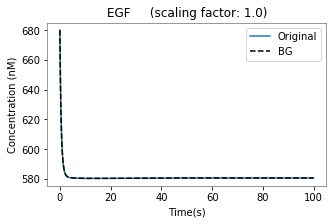

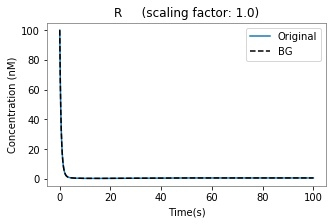

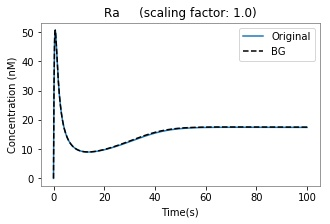

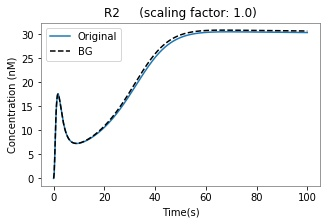

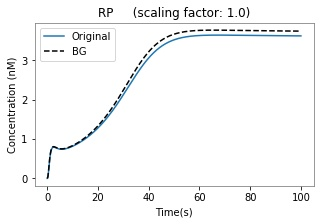

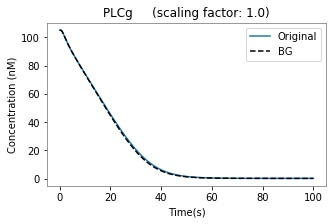

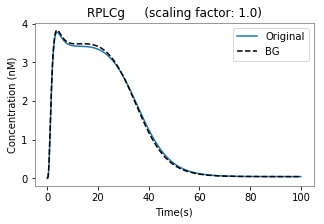

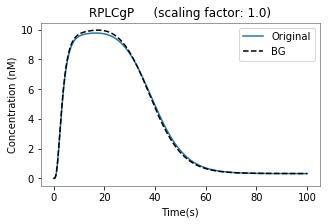

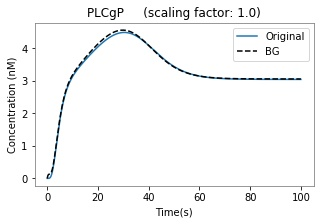

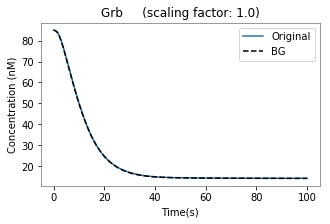

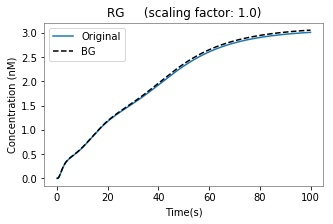

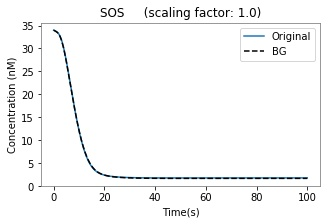

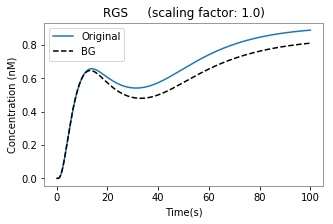

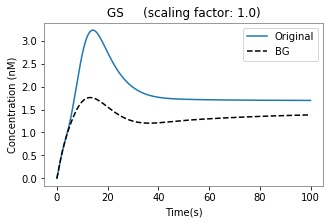

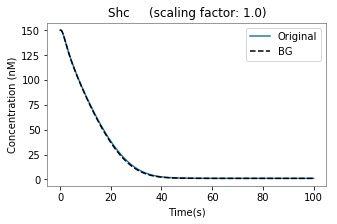

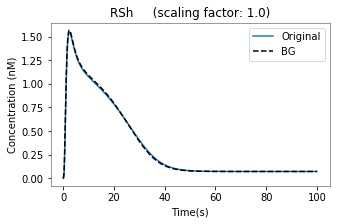

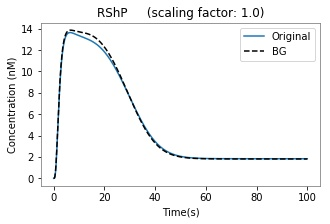

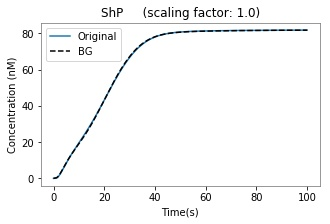

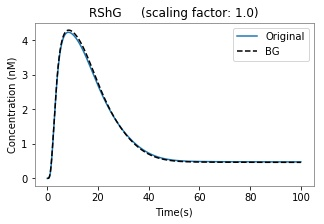

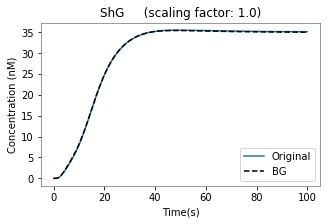

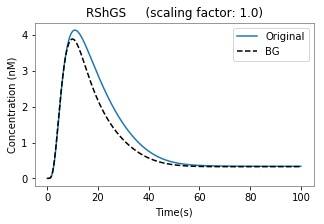

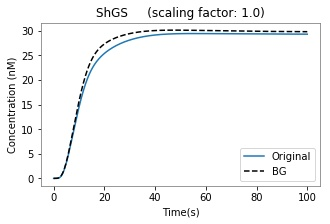

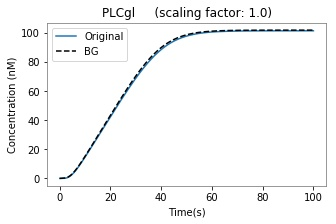

In [87]:
%config InlineBackend.figure_format = 'jpg'
rcParams['figure.figsize'] = 5, 3
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='grey')

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=12)
plt.close('all')
for stateVar,i in zip(BGmodel.state_vars,range(len(BGmodel.state_vars))): 
    for ids in idAndAnnotations:
        if str(BGmodel.state_vars[stateVar][0].name) == str(idAndAnnotations[ids]):

            plt.figure()
            plt.title(ids+'     (scaling factor: '+str(normalisationFactor)+')')
            plt.plot(unifiedSolution['Time'],unifiedSolution[ids],label='Original')
            plt.plot(t,x[:,i],'k--',label='BG')
            plt.legend(loc='best')
            plt.ylabel('Concentration ('+concentrationUnit+')')
            plt.xlabel('Time(s)')


            